<a href="https://colab.research.google.com/github/Ali-kh99/Traffic-signs-detection/blob/main/Traffic_signs_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files  

In [ ]:
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
import argparse
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os

# Load dataset
Loads our .csv  file, strips whitespace, and grabs each row via the newline delimiter, skipping the first header row. The result is a list of rows  which Line 29 then shuffles randomly.

The result of Lines 28 and 29 can be seen here

```
['33,35,5,5,28,29,13,Train/13/00013_00001_00009.png',
 '36,36,5,5,31,31,38,Train/38/00038_00049_00021.png',
 '75,77,6,7,69,71,35,Train/35/00035_00039_00024.png']
```



In [ ]:
def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []
	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)
 # loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))
		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]
		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)
# resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (32, 32))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)
		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))
	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)
  
	# return a tuple of the data and labels
	return (data, labels)

# Create our Model

In [ ]:
chanDim = -1
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
		# CONV => RELU => BN => POOL
    tf.keras.layers.Conv2D(8, (5, 5), padding="same", input_shape=(32, 32, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
		tf.keras.layers.Conv2D(16, (3, 3), padding="same"),
		tf.keras.layers.Activation("relu"),
		tf.keras.layers.BatchNormalization(axis=chanDim),
		tf.keras.layers.Conv2D(16, (3, 3), padding="same"),
		tf.keras.layers.Activation("relu"),
		tf.keras.layers.BatchNormalization(axis=chanDim),
		tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  
		# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
		tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
		tf.keras.layers.Activation("relu"),
		tf.keras.layers.BatchNormalization(axis=chanDim),
		tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
		tf.keras.layers.Activation("relu"),
		tf.keras.layers.BatchNormalization(axis=chanDim),
		tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # first set of FC => RELU layers
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128),
		tf.keras.layers.Activation("relu"),
		tf.keras.layers.BatchNormalization(),
		tf.keras.layers.Dropout(0.5),
		# second set of FC => RELU layers
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128),
		tf.keras.layers.Activation("relu"),
		tf.keras.layers.BatchNormalization(),
		tf.keras.layers.Dropout(0.5),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(43, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

In [ ]:
# local_zip = '/content/drive/MyDrive/Traffic_signs/traffic_signs_dataset.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/drive/MyDrive/Traffic_signs/traffic_signs_dataset')
# zip_ref.close()
# print("traffic_signs_dataset is unzipped")

In [ ]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# %tb
# ap.add_argument("-d", "--dataset", required=True,
# 	help="help ")
# ap.add_argument("-m", "--model", required=True,
# 	help="/content/drive/MyDrive/Traffic_signs/output")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to training history plot")
# args = vars(ap.parse_args())
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64
# load the label names
labelNames = open("/content/drive/MyDrive/Traffic_signs/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# derive the path to the training and testing CSV files
# trainPath = os.path.sep.join(["dataset", "Train.csv"])
# testPath = os.path.sep.join([args["dataset"], "Test.csv"])
# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split("/content/drive/MyDrive/Traffic_signs/traffic_signs_dataset", "/content/drive/MyDrive/Traffic_signs/traffic_signs_dataset/Test.csv")
(testX, testY) = load_split("/content/drive/MyDrive/Traffic_signs/traffic_signs_dataset", "/content/drive/MyDrive/Traffic_signs/traffic_signs_dataset/Test.csv")
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals


[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images


In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
# model = TrafficSignNet.build(width=32, height=32, depth=3,
# 	classes=numLabels)

model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BS,
	epochs=30,
  verbose=1,
	
	)

NameError: ignored

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

# save the network to disk
# print("[INFO] serializing network to '{}'...".format(args["model"]))

# model.save(args["model"])

[INFO] evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.70      0.97      0.81        60
                              Speed limit (30km/h)       0.82      0.99      0.90       720
                              Speed limit (50km/h)       0.63      0.99      0.77       750
                              Speed limit (60km/h)       0.99      0.81      0.89       450
                              Speed limit (70km/h)       0.93      0.95      0.94       660
                              Speed limit (80km/h)       0.93      0.67      0.78       630
                       End of speed limit (80km/h)       0.97      0.94      0.95       150
                             Speed limit (100km/h)       0.99      0.68      0.81       450
                             Speed limit (120km/h)       0.96      0.85      0.90       450
                                        No passing

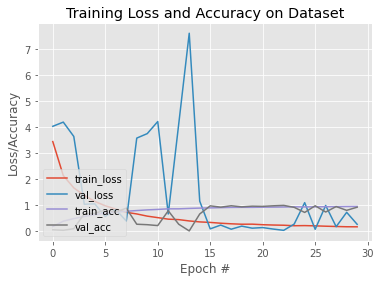

In [ ]:
# plot the training loss and accuracy
%matplotlib inline

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])

# Test your own images

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(32, 32))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0:])
  # if classes[0]>0.5:
  #   print(fn + " is a Stop sign ")
  #   print(classes[0])
  # else:
  #   print(fn + " is not a Stop sign")

KeyboardInterrupt: ignored

# Implementing our prediction script


In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
from skimage import transform
from skimage import exposure
from skimage import io
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import cv2
import os

from google.colab.patches import cv2_imshow

[INFO] loading model...
[INFO] predicting...


Saving 1200px-Road-sign-no-entry.svg.png to 1200px-Road-sign-no-entry.svg.png
Saving bf98ae75b1728612c1b6d156219b3403.jpeg to bf98ae75b1728612c1b6d156219b3403.jpeg
Saving depositphotos_49552665-stock-illustration-no-entry-road-sign.jpeg to depositphotos_49552665-stock-illustration-no-entry-road-sign.jpeg
Saving images (2).jpeg to images (2).jpeg
Saving k2-4958-2.png to k2-4958-2.png
Saving no-entry-800x800.jpeg to no-entry-800x800.jpeg
Saving reflective-stop-signs-cp1-ba_1.jpeg to reflective-stop-signs-cp1-ba_1.jpeg
Saving zYmTEaM.jpeg to zYmTEaM.jpeg
Saving images.jpeg to images (3).jpeg
Saving speed_limite_50_1.jpg to speed_limite_50_1 (1).jpg
Saving stop1.jpg to stop1 (1).jpg
Saving stop2.jpg to stop2 (1).jpg
Saving Stop7.jpeg to Stop7 (1).jpeg


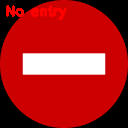

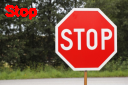

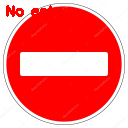

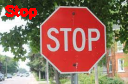

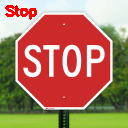

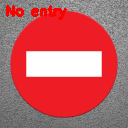

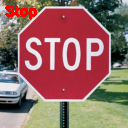

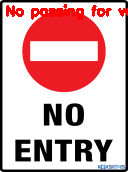

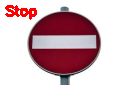

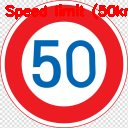

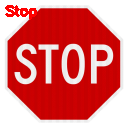

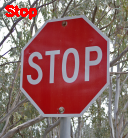

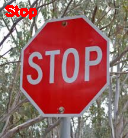

In [ ]:
# load the traffic sign recognizer model
print("[INFO] loading model...")
# load the label names
# labelNames = open("signnames.csv").read().strip().split("\n")[1:]
# labelNames = [l.split(",")[1] for l in labelNames]
# grab the paths to the input images, shuffle them, and grab a sample
print("[INFO] predicting...")

# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  imagePath = '/content/' + fn
  image = io.imread(imagePath)
  image = transform.resize(image, (32, 32))
  image = exposure.equalize_adapthist(image, clip_limit=0.1)
	# preprocess the image by scaling it to the range [0, 1]
  image = image.astype("float32") / 255.0
  image = np.expand_dims(image, axis=0)
	# make predictions using the traffic sign recognizer CNN
  preds = model.predict(image)
  j = preds.argmax(axis=1)[0]
  label = labelNames[j]
	# load the image using OpenCV, resize it, and draw the label
	# on it
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=128)
  cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
	# save the image to disk
  p = os.path.sep.join(["/content/", "{}.png".format(imagePath)])
  cv2_imshow(image)
